<a href="https://colab.research.google.com/github/jaisidhsingh/Advanced-Computer-Vision/blob/main/GANs/WDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Hyperparameters 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5  # could also use two lrs, one for gen and one for disc
CHANNELS_IMG = 1
NOISE_DIM = 128
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
BATCH_SIZE = 64
IMAGE_SIZE = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.block(x)



class ConvTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvTransposeBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x)



class Discriminator(nn.Module):
    def __init__(self, img_channels, features):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            ConvBlock(features, features*2, 4, 2, 1),
            ConvBlock(features*2, features*4, 4, 2, 1),
            ConvBlock(features*4, features*8, 4, 2, 1),
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0)
        )
    
    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            ConvTransposeBlock(noise_channels, features*16, 4, 1, 0),
            ConvTransposeBlock(features*16, features*8, 4, 2, 1),
            ConvTransposeBlock(features*8, features*4, 4, 2, 1),
            ConvTransposeBlock(features*4, features*2, 4, 2, 1),
            nn.ConvTranspose2d(features*2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)
    

def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)


In [18]:
# Train Loop:

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_disc = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        # maximize E(D(pr)) - E(D(Pg))
        for iteraion in range(CRITIC_ITERATIONS):
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) # minimize the neagative to maximize mean of f(Pr) - mean of f(Pg) as in the paper
            disc.zero_grad()
            critic_loss.backward(retain_graph=True)
            opt_disc.step()
        
            # clip weights from (-w_clip to +w_clip)
            for param in disc.parameters():
                param.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
            
        # maximize E(D(Pg))
        output = disc(fake).reshape(-1)
        gen_loss = -torch.mean(output) # maximize by minizing the negative
        gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \ Loss D: {critic_loss:.4f}, loss G: {gen_loss:.4f}")

Epoch [0/5] Batch 937/938 \ Loss D: -1.5365, loss G: 0.7256
Epoch [1/5] Batch 937/938 \ Loss D: -1.5288, loss G: 0.7235
Epoch [2/5] Batch 937/938 \ Loss D: -1.0780, loss G: 0.6575
Epoch [3/5] Batch 937/938 \ Loss D: -1.2082, loss G: 0.5831
Epoch [4/5] Batch 937/938 \ Loss D: -1.0480, loss G: 0.6400


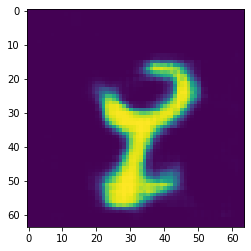

In [19]:
# Testing generator

gen.eval()

TEST_CASES = 1
test = torch.randn(TEST_CASES, NOISE_DIM, 1, 1).to(device)
output = gen(test)

output = output.detach().cpu().numpy()
output = output.reshape((output.shape[0], output.shape[2], output.shape[3]))
import matplotlib.pyplot as plt

for image in output:
    plt.imshow(image)
    plt.show()
